In [1]:
import glob
import warnings
import tarfile
import cv2

import keras
import keras.backend as K

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, LeakyReLU
from keras.layers import BatchNormalization, Activation, Conv2D
from keras.layers import GlobalAveragePooling2D, Lambda
from keras.optimizers import Adam, RMSprop

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import ImageDataGenerator 
from keras.utils import to_categorical, Sequence
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
from keras.models import load_model, model_from_json

import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
from PIL import Image
from cv2 import resize

import tensorflow as tf
from keras.applications import ResNet50
from keras import regularizers
import requests
import threading
import random
import time
import urllib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import multi_gpu_model

from collections import Counter

%matplotlib inline

print('Keras version:', keras.__version__)
# print(os.listdir('SageMaker'))

warnings.simplefilter('default')
!pwd


Using TensorFlow backend.


Keras version: 2.2.4
/home/ec2-user/SageMaker


In [2]:
n_cat = 203094
batch_size = 64
batch_size_predict = 128
input_shape = (128,128)

train_path = './landmarks/train/train/'
test_path = './landmarks/test/test/'
train_images = glob.glob(train_path+'*.jpg')
test_images = glob.glob(test_path+'*.jpg')
print(len(train_images))
print(len(test_images))
sample_submission = pd.read_csv('./landmarks/recognition_sample_submission.csv')
sample_submission.shape

4130318
112821


(117703, 2)

In [3]:
train_image_ids = [image_file.replace(
    '.jpg', '').replace(train_path, '') for image_file in train_images]

train_df = pd.DataFrame(index=list(range(0,len(train_image_ids))))
train_df['filename'] = pd.Series(train_images, index=list(range(0,len(train_image_ids))))
train_df['ids'] = train_image_ids
test_image_ids = [image_file.replace(
    '.jpg', '').replace(test_path, '') for image_file in test_images]
test_df = pd.DataFrame(index=list(range(0,len(test_image_ids))))
test_df['filename'] = pd.Series(test_images, index=list(range(0,len(test_image_ids))))
test_df['ids'] = test_image_ids

In [4]:
def check_size(url):
    r = requests.get(url, stream=True)
    return int(r.headers['Content-Length'])

def download_file(url, filename, bar=True):
    """
    Helper method handling downloading large files from `url` to `filename`. Returns a pointer to `filename`.
    """
    try:
        chunkSize = 1024
        r = requests.get(url, stream=True)
        with open(filename, 'wb') as f:
            if bar:
                pbar = tqdm( unit="B", total=int( r.headers['Content-Length'] ) )
            for chunk in r.iter_content(chunk_size=chunkSize): 
                if chunk: # filter out keep-alive new chunks
                    if bar: 
                        pbar.update (len(chunk))
                    f.write(chunk)
        return filename
    except Exception as e:
        print(e)
        return
    
def download_image_cv2_urllib(url):
    """
    Modifying the url to download the 360p or 720p version actually slows it down. 
    """
    try:
        resp = urllib.request.urlopen(url)
        foo = np.asarray(bytearray(resp.read()), dtype="uint8")
        foo = cv2.imdecode(foo, cv2.IMREAD_COLOR)
        foo = cv2.resize(foo,(128, 128), interpolation=cv2.INTER_AREA)
        return foo
    except:
        return np.array([])
    

In [5]:
train = pd.read_csv("train.csv",index_col='id')
print(train.head())
print(train.shape)
print("Number of classes {}".format(len(train.landmark_id.unique())))

NUM_THRESHOLD = 420

counts = dict(Counter(train['landmark_id']))
landmarks_dict = {x:[] for x in train.landmark_id.unique() if counts[x] >= NUM_THRESHOLD}
NUM_CLASSES = len(landmarks_dict)
print("Total number of valid classes: {}".format(NUM_CLASSES))

i = 0
landmark_to_idx = {}
idx_to_landmark = []
for k in landmarks_dict:
    landmark_to_idx[k] = i
    idx_to_landmark.append(k)
    i += 1
    
train['filename'] = pd.Series(train_images, index=train_image_ids)

all_urls = train['url'].tolist()
all_landmarks = train['landmark_id'].tolist()
valid_urls_dict = {x[0].split("/")[-1]:landmark_to_idx[x[1]] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict}
valid_urls_list = [x[0] for x in zip(all_urls, all_landmarks) if x[1] in landmarks_dict]

NUM_EXAMPLES = len(valid_urls_list)
print("Total number of valid examples: {}".format(NUM_EXAMPLES))

                                                                url  \
id                                                                    
6e158a47eb2ca3f6  https://upload.wikimedia.org/wikipedia/commons...   
202cd79556f30760  http://upload.wikimedia.org/wikipedia/commons/...   
3ad87684c99c06e1  http://upload.wikimedia.org/wikipedia/commons/...   
e7f70e9c61e66af3  https://upload.wikimedia.org/wikipedia/commons...   
4072182eddd0100e  https://upload.wikimedia.org/wikipedia/commons...   

                  landmark_id  
id                             
6e158a47eb2ca3f6       142820  
202cd79556f30760       104169  
3ad87684c99c06e1        37914  
e7f70e9c61e66af3       102140  
4072182eddd0100e         2474  
(4132914, 2)
Number of classes 203094
Total number of valid classes: 1067
Total number of valid examples: 478577


In [6]:
test_info_full = pd.read_csv('test.csv', index_col='id')
test_info_full.head()

test_info = test_info_full.loc[test_image_ids]
test_info['filename'] = pd.Series(test_images, index=test_image_ids)

test_info.head()

,url,filename
id,,
fa8d5a81a16f2f2f,https://lh3.googleusercontent.com/-_SAJTBt3Y64...,./landmarks/test/test/fa8d5a81a16f2f2f.jpg
b81a0a45f9b1ee97,https://lh3.googleusercontent.com/-9sFSIOCzIOs...,./landmarks/test/test/b81a0a45f9b1ee97.jpg
570e28cc63fab858,https://lh3.googleusercontent.com/-7Eld7yUfAB0...,./landmarks/test/test/570e28cc63fab858.jpg
b8bc63608b5fef1a,https://lh3.googleusercontent.com/-JdgzGjeS9NE...,./landmarks/test/test/b8bc63608b5fef1a.jpg
54cfd1f5f683b966,https://lh3.googleusercontent.com/-krCM7YZ3FpU...,./landmarks/test/test/54cfd1f5f683b966.jpg


In [7]:
label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=True, n_values=n_cat)

train['label'] = label_encoder.fit_transform(train['landmark_id'])
train['one_hot'] = one_hot_encoder.fit_transform(
                    train['label'].values.reshape(-1, 1))

In [8]:
train.head()

,url,landmark_id,filename,label,one_hot
id,,,,,
6e158a47eb2ca3f6,https://upload.wikimedia.org/wikipedia/commons...,142820,./landmarks/train/train/6e158a47eb2ca3f6.jpg,142820,"(0, 142820)\t1.0\n (1, 104169)\t1.0\n (2, ..."
202cd79556f30760,http://upload.wikimedia.org/wikipedia/commons/...,104169,./landmarks/train/train/202cd79556f30760.jpg,104169,"(0, 142820)\t1.0\n (1, 104169)\t1.0\n (2, ..."
3ad87684c99c06e1,http://upload.wikimedia.org/wikipedia/commons/...,37914,./landmarks/train/train/3ad87684c99c06e1.jpg,37914,"(0, 142820)\t1.0\n (1, 104169)\t1.0\n (2, ..."
e7f70e9c61e66af3,https://upload.wikimedia.org/wikipedia/commons...,102140,./landmarks/train/train/e7f70e9c61e66af3.jpg,102140,"(0, 142820)\t1.0\n (1, 104169)\t1.0\n (2, ..."
4072182eddd0100e,https://upload.wikimedia.org/wikipedia/commons...,2474,./landmarks/train/train/4072182eddd0100e.jpg,2474,"(0, 142820)\t1.0\n (1, 104169)\t1.0\n (2, ..."


In [9]:
def load_images(info, input_shape = input_shape):
    input_shape = tuple(input_shape)
    imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))

    for i in range(len(info)):
        fname = info.iloc[i]['filename']
        try:
            img = cv2.cvtColor(
                  cv2.resize(cv2.imread(fname),input_shape),
                  cv2.COLOR_BGR2RGB)
        except:
            warnings.warn('Warning: could not read image: '+ fname +
                          '. Use black img instead.')
            img = np.zeros((input_shape[0], input_shape[1], 3))
        imgs[i,:,:,:] = img
    
    return imgs
def load_cropped_images(info, crop_p=0.2, crop='random'):
    new_res = np.array([int(input_shape[0]*(1+crop_p)), int(input_shape[1]*(1+crop_p))])
    if crop == 'random':
        cx0 = np.random.randint(new_res[0] - input_shape[0], size=len(info))
        cy0 = np.random.randint(new_res[1] - input_shape[1], size=len(info))
    else:
        if crop == 'central':
            cx0, cy0 = (new_res - input_shape) // 2                
        if crop == 'upper left':
            cx0, cy0 = 0, 0
        if crop == 'upper right':
            cx0, cy0 = new_res[1] - input_shape[1], 0
        if crop == 'lower left':
            cx0, cy0 = 0, new_res[0] - input_shape[0]
        if crop=='lower right':
            cx0, cy0 = new_res - input_shape        
        cx0 = np.repeat(np.expand_dims(cx0, 0), len(info))
        cy0 = np.repeat(np.expand_dims(cy0, 0), len(info))

    cx1 = cx0 + input_shape[0]
    cy1 = cy0 + input_shape[1]
    
    raw_imgs = load_images(info, input_shape=tuple(new_res))
    
    cropped_imgs = np.zeros((len(info), input_shape[0], input_shape[1], 3))
    for ind in range(len(info)):
        cropped_imgs[ind,:,:,:] = raw_imgs[ind,
                                           cy0[ind]:cy1[ind],
                                           cx0[ind]:cx1[ind], :]
    
    return cropped_imgs


def get_image_gen(info_arg, 
                  shuffle=True, 
                  image_aug=True, 
                  eq_dist=False, 
                  n_ref_imgs=16, 
                  crop_prob=0.5, 
                  crop_p=0.5):
    if image_aug:
        datagen = ImageDataGenerator(
            rotation_range=4.,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.5,
            channel_shift_range=25,
            horizontal_flip=True,
            fill_mode='nearest')
        
        if crop_prob > 0:
            datagen_crop = ImageDataGenerator(
                rotation_range=4.,
                shear_range=0.2,
                zoom_range=0.1,
                channel_shift_range=20,
                horizontal_flip=True,
                fill_mode='nearest')
        
    count = len(info_arg)
    while True:
        if eq_dist:
            def sample(df):
                return df.sample(min(n_ref_imgs, len(df)))
            info = info_arg.groupby('landmark_id', group_keys=False).apply(sample)
        else:
            info = info_arg
        print('Generate', len(info), 'for the next round.')
        
        #shuffle data
        if shuffle and count >= len(info):
            info = info.sample(frac=1)
            count = 0
            
        # load images
        for ind in range(0,len(info), batch_size):
            count += batch_size

            y = info['landmark_id'].values[ind:(ind+batch_size)]
            
            if np.random.rand() < crop_prob:
                imgs = load_cropped_images(info.iloc[ind:(ind+batch_size)], 
                                           crop_p=crop_p*np.random.rand() + 0.01, 
                                           crop='random')
                if image_aug:
                    cflow = datagen_crop.flow(imgs, 
                                              y, 
                                              batch_size=imgs.shape[0], 
                                              shuffle=False)
                    imgs, y = next(cflow)                    
            else:
                imgs = load_images(info.iloc[ind:(ind+batch_size)])
                if image_aug:
                    cflow = datagen.flow(imgs, 
                                       y, 
                                       batch_size=imgs.shape[0], 
                                       shuffle=False)
                    imgs, y = next(cflow)             

            imgs = preprocess_input(imgs)
    
            y_l = label_encoder.transform(y[y>=0.])        
            y_oh = np.zeros((len(y), n_cat))
            y_oh[y >= 0., :] = one_hot_encoder.transform(y_l.reshape(-1,1)).todense()
                    
            yield imgs, y_oh
            
train_gen = get_image_gen(train, 
                          eq_dist=False, 
                          n_ref_imgs=256, 
                          crop_prob=0.5, 
                          crop_p=0.5)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/preprocessing/image.py:440: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  image.ImageDataGenerator.__init__).args:


Generate 4132914 for the next round.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


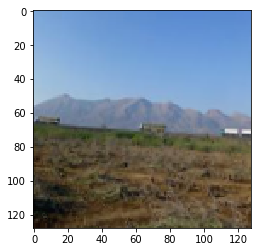

In [10]:
X_example, y_example = next(train_gen)
plt.imshow(X_example[1,:,:,:]/2. + 0.5)

In [11]:
K.clear_session()

In [12]:
with open('model.json', 'r') as f:
    model = model_from_json(f.read())

model.load_weights('model_weights.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
model.layers

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [16]:
def predict(info, load_n_images=1024):
    n = len(info)
    max_p = np.zeros(n)
    pred = np.zeros(n)
    
    for ind in range(0,len(info),load_n_images):
        imgs = load_images(info.iloc[ind:(ind+load_n_images)])
        imgs = preprocess_input(imgs)
        proba = model.predict(imgs, batch_size=batch_size_predict)
        
        pred_i = np.argmax(proba, axis=1)
        max_p[ind:(ind + load_n_images)] = proba[np.arange(len(pred_i)),pred_i]
        pred[ind:(ind + load_n_images)] = label_encoder.inverse_transform(pred_i)
        
        print(ind, '/', len(info), '  -->', pred[ind], max_p[ind])

    print(len(info), '/', len(info), '  -->', pred[-1], max_p[-1])
    
    return pred, max_p

def predict_wcr_vote(info, load_n_images=1024, crop_p=0.1):
    n = len(info)
    max_p = np.zeros(n)
    pred = np.zeros(n)
    
    for ind in range(0,len(info),load_n_images):
        n_crops = 12
        all_proba = np.zeros((n_crops, min(load_n_images, len(info)-ind), n_cat))
        
        imgs = load_images(info.iloc[ind:(ind+load_n_images)])
        imgs = preprocess_input(imgs)
        
        #full image
        all_proba[0,:,:] = model.predict(imgs, batch_size=batch_size_predict)
        all_proba[1,:,:] = model.predict(np.flip(imgs, axis=2), 
                                         batch_size=batch_size_predict)
        
        crops = ['upper left', 'lower left', 'upper right', 'lower right', 'central']
        jnd_0 = 2
        for jnd,crop in enumerate(crops):
            imgs = load_cropped_images(info.iloc[ind:(ind+load_n_images)], 
                                  crop_p=crop_p, crop=crop)  # optimize later
            imgs = preprocess_input(imgs)
            all_proba[jnd_0+2*jnd,:,:] = model.predict(imgs, 
                                                       batch_size=batch_size_predict)
            all_proba[jnd_0+2*jnd+1,:,:] = model.predict(np.flip(imgs, axis=2), 
                                                         batch_size=batch_size_predict)
        
        cmax_p = np.zeros((n_crops,imgs.shape[0]))
        cpred = np.zeros((n_crops,imgs.shape[0]))
        for jnd in range(all_proba.shape[0]):
            proba = all_proba[jnd,:,:]
            pred_i = np.argmax(proba, axis=1)
            cmax_p[jnd,:] = proba[np.arange(len(pred_i)),pred_i]
            cpred[jnd,:] = label_encoder.inverse_transform(pred_i)
        
        for knd in range(imgs.shape[0]):
            c_res = pd.DataFrame({'max_cat':cpred[:,knd], 'max_p':cmax_p[:,knd]})
            c_res = c_res.groupby('max_cat').aggregate('sum') / n_crops
            pred[ind + knd]=c_res['max_p'].idxmax()
            max_p[ind + knd]=c_res.loc[pred[ind + knd]]['max_p']
                  
        print(ind,'/',len(info), '  -->', pred[ind], max_p[ind])
    print(len(info),'/',len(info), '  -->', pred[-1], max_p[-1])
    
    return pred, max_p

def validate(info, load_n_images=1024, wcr=False, crop_p=0.1):
    if wcr:
        pred, max_p = predict_wcr_vote(info, load_n_images=load_n_images, crop_p=crop_p)
    else:
        pred, max_p = predict(info, load_n_images=load_n_images)
    
    y = info['landmark_id'].values
    binary_acc = accuracy_score(y, pred)

    sort_ind = np.argsort(max_p)[::-1]

    pred = pred[sort_ind]
    y_true = y[sort_ind]

    GAP = np.sum(np.cumsum(pred == y_true)
                 * (pred == y_true) / np.arange(1, len(y_true) + 1)) / np.sum(y_true >= 0.)

    print("accuracy:", binary_acc, "\n ")
    print("*** GAP:", GAP, "***")
    
    return binary_acc, GAP


In [38]:
test_pred, test_max_p = predict_wcr_vote(test_info, 512, crop_p=0.1)


ValueError: could not broadcast input array from shape (512,1067) into shape (512,203094)

In [19]:
test_info_full = pd.read_csv('test.csv', index_col=0)
test_info_full.head()

,url
id,
cb9998b8cdaf6235,https://lh3.googleusercontent.com/-q8B91vDIQZY...
30728cf6e50a6bc6,https://lh3.googleusercontent.com/-91gJSKTgv5Q...
16afbc86b710337d,https://lh3.googleusercontent.com/-GHZdXuf2wMg...
d29b2166cf522450,https://lh3.googleusercontent.com/-cWDnYNQhyws...
dd5c03b20c21cfba,https://lh3.googleusercontent.com/-PSLN6BloM-k...


In [20]:
predictions = pd.DataFrame(columns=['landmarks'], index=test_info.index)
predictions['landmarks'] = [str(int(tp))+' '+ '%.16g' % pp 
                            for tp,pp in zip(test_pred, test_max_p)]
predictions.head()

,landmarks
id,
fa8d5a81a16f2f2f,427 0.08140573650598526
b81a0a45f9b1ee97,907 0.1044744327664375
570e28cc63fab858,141 0.05056074634194374
b8bc63608b5fef1a,907 0.06476124376058578
54cfd1f5f683b966,427 0.06466788053512573


In [24]:
missing = test_info_full[test_info_full.index.isin(test_info.index)!=True]
missing_predictions = pd.DataFrame(index=missing.index)
missing_predictions['landmarks'] = '9633 0.0'
missing_predictions.head()

,landmarks
id,
5b2f6f17b4186812,9633 0.0
2ea9be33f6ebecca,9633 0.0
280395b8faed020f,9633 0.0
aaedf535b504f3a4,9633 0.0
99cc2708719dd7eb,9633 0.0


In [25]:
completed_predictions = pd.concat([predictions, missing_predictions])
print(len(completed_predictions))

117703


In [26]:
sorted_predictions = pd.DataFrame(index=test_info_full.index)
sorted_predictions['landmarks'] = completed_predictions['landmarks']
sorted_predictions.tail()

,landmarks
id,
acb1f9c42f092e44,427 0.04229553043842316
c855de19f6e30bbb,907 0.06786996126174927
3cc69ce565d75a33,907 0.0876278430223465
7d37d209e813e000,427 0.05505924299359322
5246445f426d1d97,141 0.06766840070486069


In [29]:
sorted_predictions.shape

(117703, 1)

In [36]:
sorted_predictions.to_csv('prediction_c12.csv',index=True)

In [37]:
ex = pd.read_csv('prediction_c12.csv')
ex.head()

,id,landmarks
0,cb9998b8cdaf6235,907 0.04887742176651955
1,30728cf6e50a6bc6,907 0.09091679751873016
2,16afbc86b710337d,427 0.05594142526388168
3,d29b2166cf522450,427 0.06347589194774628
4,dd5c03b20c21cfba,907 0.08829095214605331


In [36]:
# x_model = Xception(input_shape=list(input_shape) + [3], 
#                    weights='imagenet', 
#                    include_top=False)


In [ ]:
# x_model.summary()
# # 

In [ ]:
# print((x_model.layers[85]).name)
# print((x_model.layers[25]).name)
# print((x_model.layers[15]).name)

In [ ]:
# for layer in x_model.layers:
#     layer.trainable = True

# for layer in x_model.layers[:85]:
#     layer.trainable = False   
    
# x_model.summary()

In [ ]:
# gm_exp = tf.Variable(3., dtype=tf.float32)
# def generalized_mean_pool_2d(X):
#     pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
#                            axis=[1,2], 
#                            keepdims=False)+1.e-8)**(1./gm_exp)
#     return pool


In [ ]:
# X_feat = Input(x_model.output_shape[1:])

# lambda_layer = Lambda(generalized_mean_pool_2d)
# lambda_layer.trainable_weights.extend([gm_exp])
# X = lambda_layer(X_feat)
# X = Dropout(0.05)(X)
# X = Activation('relu')(X)
# X = Dense(n_cat, activation='softmax')(X)

# top_model = Model(inputs=X_feat, outputs=X)
# top_model.summary()

In [ ]:
# X_image = Input(list(input_shape) + [3])

# X_f = x_model(X_image)
# X_f = top_model(X_f)

# model = Model(inputs=X_image, outputs=X_f)
# model.summary()

In [43]:
# def get_custom_loss(rank_weight=1., epsilon=1.e-9):
#     def custom_loss(y_t, y_p):
#         losses = tf.reduce_sum(-y_t*tf.log(y_p+epsilon) - (1.-y_t)*tf.log(1.-y_p+epsilon), 
#                                axis=-1)
        
#         pred_idx = tf.argmax(y_p, axis=-1)
        
#         mask = tf.one_hot(pred_idx, 
#                           depth=y_p.shape[1], 
#                           dtype=tf.bool, 
#                           on_value=True, 
#                           off_value=False)
#         pred_cat = tf.boolean_mask(y_p, mask)
#         y_t_cat = tf.boolean_mask(y_t, mask)
        
#         n_pred = tf.shape(pred_cat)[0]
#         _, ranks = tf.nn.top_k(pred_cat, k=n_pred)
        
#         ranks = tf.cast(n_pred-ranks, tf.float32)/tf.cast(n_pred, tf.float32)*rank_weight
#         rank_losses = ranks*(-y_t_cat*tf.log(pred_cat+epsilon)
#                              -(1.-y_t_cat)*tf.log(1.-pred_cat+epsilon))        
        
#         return rank_losses + losses
#     return custom_loss

In [44]:
# def batch_GAP(y_t, y_p):
#     pred_cat = tf.argmax(y_p, axis=-1)    
#     y_t_cat = tf.argmax(y_t, axis=-1) * tf.cast(
#         tf.reduce_sum(y_t, axis=-1), tf.int64)
    
#     n_pred = tf.shape(pred_cat)[0]
#     is_c = tf.cast(tf.equal(pred_cat, y_t_cat), tf.float32)

#     GAP = tf.reduce_mean(
#           tf.cumsum(is_c) * is_c / tf.cast(
#               tf.range(1, n_pred + 1), 
#               dtype=tf.float32))
    
#     return GAP

In [45]:
# def binary_crossentropy_n_cat(y_t, y_p):
#     return keras.metrics.binary_crossentropy(y_t, y_p) * n_cat

In [48]:
# opt = Adam(lr=0.0001)
# loss = get_custom_loss(1.0)
# model = multi_gpu_model(model, gpus=8)
# model.compile(loss=loss, 
#               optimizer=opt, 
#               metrics=[binary_crossentropy_n_cat, 'accuracy', batch_GAP])

In [ ]:
# K.tensorflow_backend._get_available_gpus()

In [50]:
# checkpoint1 = ModelCheckpoint('dd_checkpoint-1.h5', 
#                               period=1, 
#                               verbose=1, 
#                               save_weights_only=True)
# checkpoint2 = ModelCheckpoint('dd_checkpoint-2.h5', 
#                               period=1, 
#                               verbose=1, 
#                               save_weights_only=True)
# checkpoint3 = ModelCheckpoint('dd_checkpoint-3-best.h5', 
#                               period=1, 
#                               verbose=1, 
#                               monitor='loss', 
#                               save_best_only=True, 
#                               save_weights_only=True)

In [53]:
# model.fit_generator(train_gen, 
#                     steps_per_epoch=len(train) / batch_size / 8, 
#                     epochs=50, 
#                     callbacks=[checkpoint1, checkpoint2, checkpoint3])